In [2]:
import sys

!{sys.executable} -m pip install sagemaker pandas numpy --upgrade

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.0/668.0 kB 8.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 34.6 MB/s eta 0:00:0000:0100:01
  Created wheel for sagemaker: filename=sagemaker-2.132.0-py2.py3-none-any.whl size=905463 sha256=3ee9ec10d2c8c35586190d7d26aed50390b281bd360c833234860647f7a7bc75
  Stored in directory: /root/.cache/pip/wheels/9c/37/48/50ed95c0d9cc55c9fcd9e6f0202328d5d0ad7bb2f62ec32288
Successfully built sagemaker
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.24
    Uninstalling botocore-1.29.24:
      Successful

In [4]:
import sagemaker

#provide required sagemaker services access
sess = sagemaker.Session()

#create default bucket
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-xgboost-churn"

# Define IAM role
import boto3 #python SDK -provides python APIs for AWS infrastructure services
import re
from sagemaker import get_execution_role

#store IAM role
role = get_execution_role()

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plts
import os 
from IPython.display import display


#to insert required parameters to train model
from sagemaker.inputs import TrainingInput

#to conver files into csv
from sagemaker.serializers import CSVSerializer

In [9]:
#to create API call from s3
s3 = boto3.client("s3")
s3.download_file(f"sagemaker-sample-files", "datasets/tabular/synthetic/churn.txt", "churn.txt")


In [18]:
#variable created to store churn data
churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
churn


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9,False.
4996,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4,False.
4997,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6,False.
4998,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7,True.


In [19]:
print(churn.columns)
len(churn.columns)


Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?'],
      dtype='object')


21

In [20]:
display(churn.describe())

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


In [21]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)

In [29]:
#display correlation between features
display(churn.corr())


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.009030,-0.015878,0.011659,-0.007468,0.000213,0.026515,-0.012795,0.016400,-0.002383,-0.034925,0.017277,-0.003735,0.028285,-0.036721
VMail Message,-0.009030,1.000000,-0.143272,0.002762,-0.182712,-0.104667,-0.101240,-0.029212,0.061370,0.135042,-0.155475,-0.015162,0.131964,0.010120,0.068657
Day Mins,-0.015878,-0.143272,1.000000,-0.087598,0.667941,0.482641,-0.184939,0.766489,0.188190,-0.445212,0.570508,0.001988,0.236131,0.239331,-0.195322
Day Calls,0.011659,0.002762,-0.087598,1.000000,-0.222556,0.033903,0.185881,-0.052051,-0.085222,-0.083050,0.046641,-0.022548,-0.045671,-0.120064,-0.065518
Day Charge,-0.007468,-0.182712,0.667941,-0.222556,1.000000,0.574697,0.236626,0.371580,0.150700,-0.130722,0.374861,0.010294,0.119584,0.251748,-0.260945
Eve Mins,0.000213,-0.104667,0.482641,0.033903,0.574697,1.000000,-0.067123,0.269980,-0.090515,0.067315,0.317481,-0.015678,0.070456,0.448910,-0.167347
Eve Calls,0.026515,-0.101240,-0.184939,0.185881,0.236626,-0.067123,1.000000,-0.467814,0.221439,0.218149,-0.324936,-0.001593,-0.112062,0.017036,-0.433467
Eve Charge,-0.012795,-0.029212,0.766489,-0.052051,0.371580,0.269980,-0.467814,1.000000,0.184230,-0.454649,0.546137,-0.003569,0.164104,0.243936,-0.011019
Night Mins,0.016400,0.061370,0.188190,-0.085222,0.150700,-0.090515,0.221439,0.184230,1.000000,-0.223023,-0.140482,-0.012781,0.038831,0.271179,-0.332802
Night Calls,-0.002383,0.135042,-0.445212,-0.083050,-0.130722,0.067315,0.218149,-0.454649,-0.223023,1.000000,-0.390333,-0.009821,0.181237,-0.155736,0.110211


In [30]:
churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

In [31]:
#convert categorical features into numerical features
model_data = pd.get_dummies(churn)
model_data = pd.concat(
    [model_data["Churn?_True."], model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)], axis=1)

In [32]:
#split data into train, validation and test data
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

#save train data into train.csv
train_data.to_csv("train.csv", header=False, index=False)

#save validation data into validation.csv
validation_data.to_csv("validation.csv", header=False, index=False)

In [33]:

len(train_data.columns)

100

In [34]:
#upload train dataset into s3 default created bucket
train_dataset = boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")

#upload validation dataset into s3 default created bucket
validation_dataset = boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

In [36]:
#create a container to store algorithm name, region
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")
display(container)

'720646828776.dkr.ecr.ap-south-1.amazonaws.com/sagemaker-xgboost:1.5-1'

In [35]:
#variable created to store s3 URI for input data
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)

#variable created to store s3 URI for validation data
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

max_depth:</br>
controls how deep each tree within the algorithm can be built. Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting. There is typically some trade-off in model performance that needs to be explored between numerous shallow trees and a smaller number of deeper trees.

subsample:</br>
controls sampling of the training data. This technique can help reduce overfitting, but setting it too low can also starve the model of data.

num_round: </br>
controls the number of boosting rounds. This is essentially the subsequent models that are trained using the residuals of previous iterations. Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.

eta:</br>
controls how aggressive each round of boosting is. Larger values lead to more conservative boosting.

gamma:</br>
controls how aggressively trees are grown. Larger values lead to more conservative models.

In [40]:
#variable created 
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="binary:logistic",
    num_round=100,
)



In [41]:
# fit train and validatin data into model
xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-16-06-14-11-735


2023-02-16 06:14:11 Starting - Starting the training job...
2023-02-16 06:14:37 Starting - Preparing the instances for training......
2023-02-16 06:15:34 Downloading - Downloading input data...
2023-02-16 06:16:04 Training - Downloading the training image...
2023-02-16 06:16:40 Training - Training image download completed. Training in progress....
2023-02-16 06:17:06 Uploading - Uploading generated training model[2023-02-16 06:16:57.082 ip-10-0-65-233.ap-south-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-16:06:16:57:INFO] Imported framework sagemaker_xgboost_container.training
[2023-02-16:06:16:57:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2023-02-16:06:16:57:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-16:06:16:57:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-02-16:06:16:57:INFO] Determined delimiter of CSV input is ','
[2023-02-16:06:16:57:INFO] Determined 

In [42]:
#deploy ML model and create endpoint
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-02-16-06-20-35-922
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-02-16-06-20-35-922
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-02-16-06-20-35-922


------!

In [39]:
"""
    Loop over our test dataset
    Split it into mini-batches of rows
    Convert those mini-batchs to CSV string payloads
    Retrieve mini-batch predictions by invoking the XGBoost endpoint
    Collect predictions and convert from the CSV output our model provides into a NumPy array
"""

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return predictions.split("\n")[:-1]


predictions = predict(test_data.to_numpy()[:, 1:])

In [49]:
#variable created to store the prediction output
import math
# predictions = np.array([float(num) for num in predictions])
predictions = np.array([round(float(num),0) for num in predictions])
print(predictions)

[0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.

In [50]:

#comparing actual to predicted values
pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,0.0,1.0
actual,,
0,235,18
1,11,236


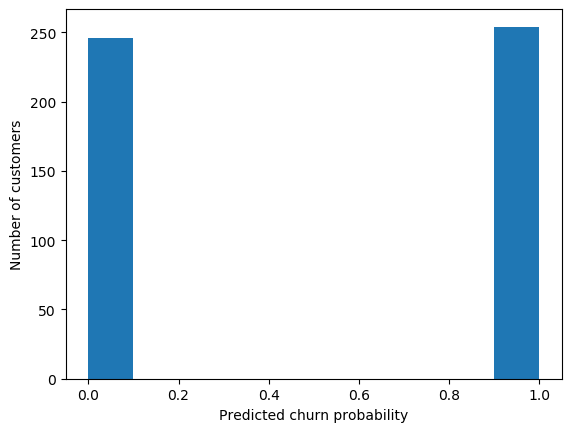

In [51]:
#plot histogram of predictions
plt.hist(predictions)
plt.xlabel("Predicted churn probability")
plt.ylabel("Number of customers")
plt.show()

In [52]:
#delete created endpointsd
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-02-16-06-20-35-922
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-02-16-06-20-35-922
